### Testing pre-trained wav2vec 2.0 Model with CMU_ARCTIC dataset

In [ ]:
!pip install torchaudio

In [1]:
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.12.1
0.12.1+cpu
cuda


In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
model = bundle.get_model().to(device)
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [26]:
!pip install torch-summary

In [33]:
summary(model)

Layer (type:depth-idx)                                  Param #
├─FeatureExtractor: 1-1                                 --
|    └─ModuleList: 2-1                                  --
|    |    └─ConvLayerBlock: 3-1                         6,144
|    |    └─ConvLayerBlock: 3-2                         786,432
|    |    └─ConvLayerBlock: 3-3                         786,432
|    |    └─ConvLayerBlock: 3-4                         786,432
|    |    └─ConvLayerBlock: 3-5                         786,432
|    |    └─ConvLayerBlock: 3-6                         524,288
|    |    └─ConvLayerBlock: 3-7                         524,288
├─Encoder: 1-2                                          --
|    └─FeatureProjection: 2-2                           --
|    |    └─LayerNorm: 3-8                              1,024
|    |    └─Linear: 3-9                                 393,984
|    |    └─Dropout: 3-10                               --
|    └─Transformer: 2-3                                 --
|    |    

Layer (type:depth-idx)                                  Param #
├─FeatureExtractor: 1-1                                 --
|    └─ModuleList: 2-1                                  --
|    |    └─ConvLayerBlock: 3-1                         6,144
|    |    └─ConvLayerBlock: 3-2                         786,432
|    |    └─ConvLayerBlock: 3-3                         786,432
|    |    └─ConvLayerBlock: 3-4                         786,432
|    |    └─ConvLayerBlock: 3-5                         786,432
|    |    └─ConvLayerBlock: 3-6                         524,288
|    |    └─ConvLayerBlock: 3-7                         524,288
├─Encoder: 1-2                                          --
|    └─FeatureProjection: 2-2                           --
|    |    └─LayerNorm: 3-8                              1,024
|    |    └─Linear: 3-9                                 393,984
|    |    └─Dropout: 3-10                               --
|    └─Transformer: 2-3                                 --
|    |    

In [19]:
waveform_, sample_rate_ = torchaudio.load('arctic_wav/wav/arctic_a0001.wav')
waveform_ = waveform_.to(device)

In [28]:
waveform_.shape

torch.Size([1, 64000])

In [20]:
with torch.inference_mode():
    features_, _ = model.extract_features(waveform_)

In [21]:
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

In [22]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

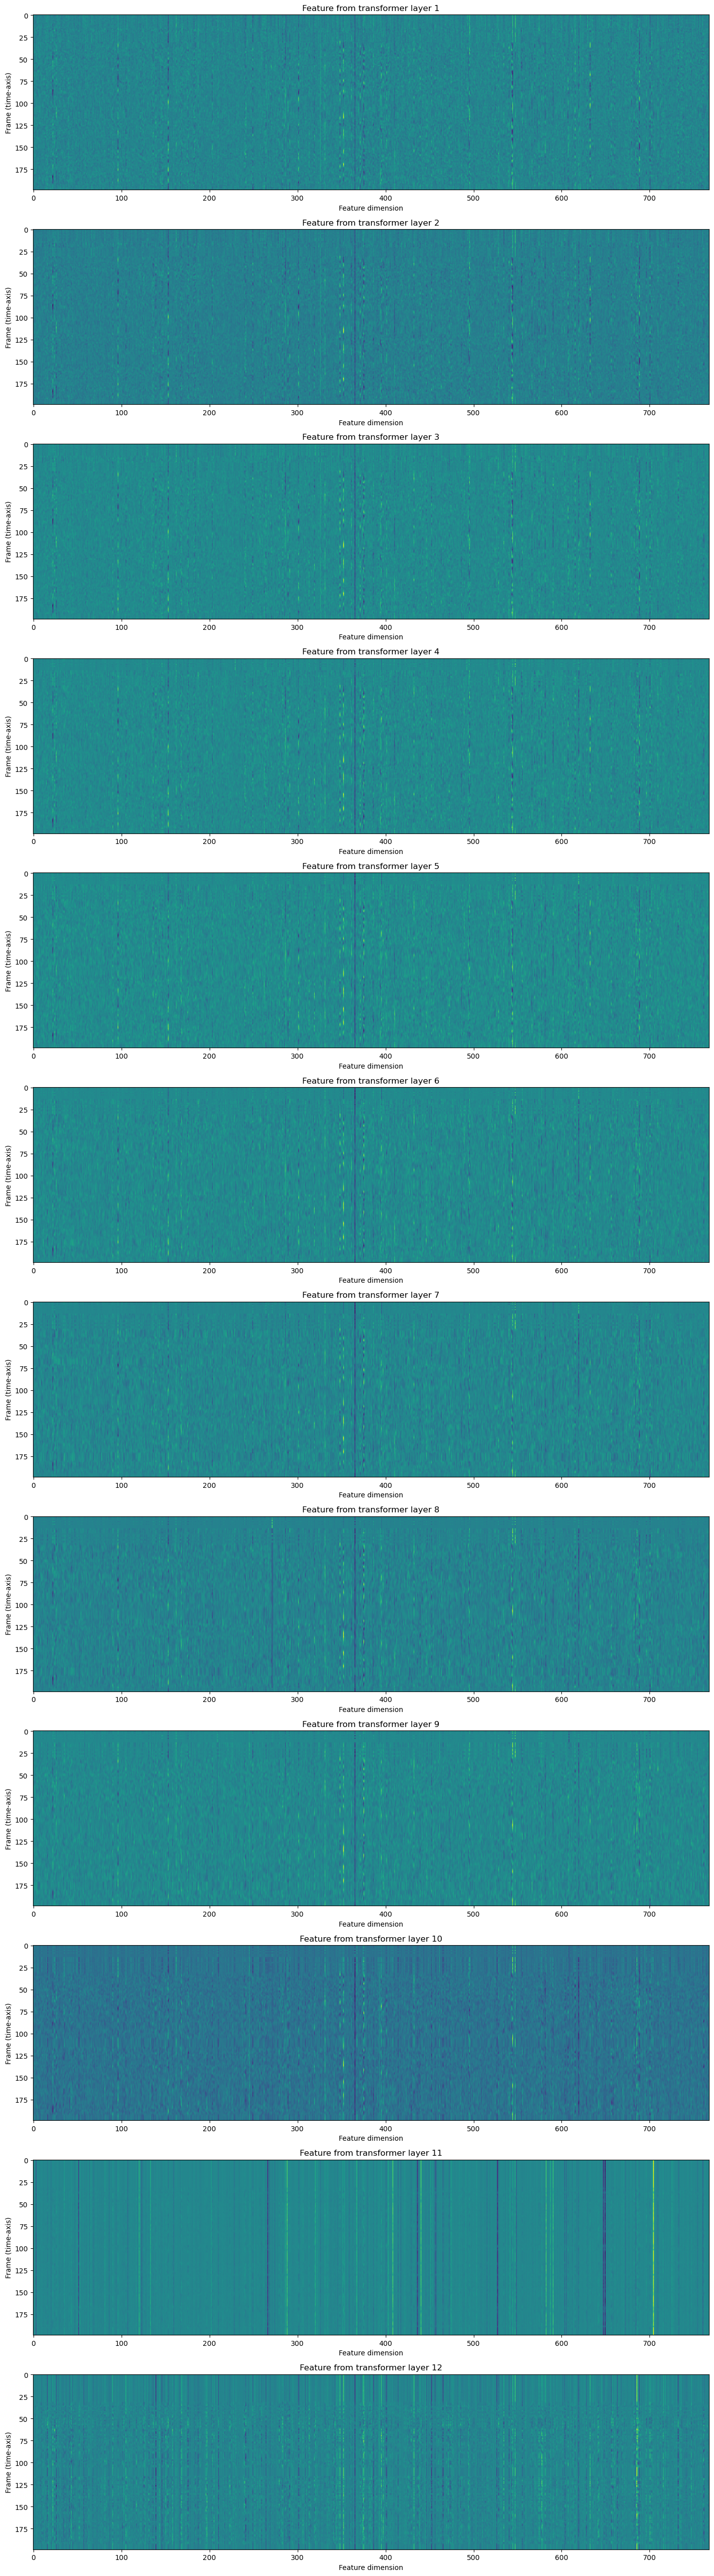

In [23]:
fig, ax = plt.subplots(len(features_), 1, figsize=(16, 4.3 * len(features_)))
for i, feats in enumerate(features_):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [24]:
with torch.inference_mode():
    emission_, _ = model(waveform_)

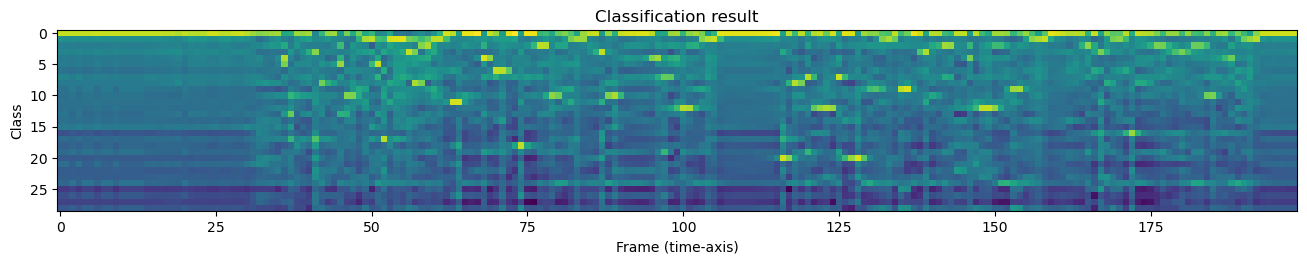

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [25]:
plt.imshow(emission_[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [5]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
!pip install jiwer

In [6]:
from jiwer import wer

In [7]:
import csv

In [8]:
def get_ground_truth_labels():
    ground_truths = {}
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    with open('./arctic_wav/transcript.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            no_punc = ""
            inp_str = row[1]
            for char in inp_str:
                if char not in punctuations:
                    no_punc = no_punc + char
            tr = no_punc.lower()
            fn = row[0]+".wav"
            ground_truths[fn] = tr
    return ground_truths

In [9]:
truth_labels = get_ground_truth_labels()

In [10]:
import os

In [11]:
def get_files():
    wav_files = {}
    for f in os.listdir("arctic_wav/wav/"):
        file_path = "arctic_wav/wav/" + f
        wav_files[f]=file_path
    return wav_files

In [12]:
wav_files = get_files()

In [13]:
ground_truths = []
hypothesis = []

# error = wer(ground_truth, hypothesis)
for fn in wav_files:
    if fn in truth_labels.keys():
        speech_file_path = wav_files[fn]
        truth = truth_labels[fn]
        ground_truths.append(truth)
        waveform, sample_rate = torchaudio.load(speech_file_path)
        waveform = waveform.to(device)
        with torch.inference_mode():
            emission, _ = model(waveform)
            decoder = GreedyCTCDecoder(labels=bundle.get_labels())
            transcript = decoder(emission[0])
            words = transcript.split("|")
            clean_output = ""
            for word in words:
                clean_output = clean_output +' '+ word.lower()
            clean_output = clean_output.strip()
            hypothesis.append(clean_output)

In [14]:
print(hypothesis)

['author of the danger trail philip steals et cetera', 'not at this particular case tom apologized whitmore', 'for the twentieth time that evening the two men shook hands', 'lord but i am glad to see you again phil', 'will we ever forget it', 'god bless him i hope i will go on seeing them for ever', 'and you always want to see it in the superlative degree', 'gad your letter came just in time', 'he turned sharply and faced greggson across the table', "i'm playing a single hand in what looks like a losing game", 'if i ever needed a fighter in my life i need one now', 'gregson shoved back his chair and rose to his feet', 'he was ahead shorter than his companion of almost delicate physique', 'now you are coming down to business phil he exclaimed', "it's the aurura borialis", "there's fort churchill a rifle shot beyond the redge asleep", 'from that moment his friendship for belies turns to hatred and jealousy', 'there was a change now', 'i followed the line of the proposed railroad looking 

In [15]:
print(ground_truths)

['author of the danger trail philip steels etc', 'not at this particular case tom apologized whittemore', 'for the twentieth time that evening the two men shook hands', 'lord but im glad to see you again phil', 'will we ever forget it', 'god bless em i hope ill go on seeing them forever', 'and you always want to see it in the superlative degree', 'gad your letter came just in time', 'he turned sharply and faced gregson across the table', 'im playing a single hand in what looks like a losing game', 'if i ever needed a fighter in my life i need one now', 'gregson shoved back his chair and rose to his feet', 'he was a head shorter than his companion of almost delicate physique', 'now youre coming down to business phil he exclaimed', 'its the aurora borealis', 'theres fort churchill a rifleshot beyond the ridge asleep', 'from that moment his friendship for belize turns to hatred and jealousy', 'there was a change now', 'i followed the line of the proposed railroad looking for chances', 'cl

In [17]:
error = wer(ground_truths, hypothesis)
error

0.09432823813354786